100%|██████████| 2000/2000 [00:16<00:00, 119.80it/s]


(-5.0, 0.0)

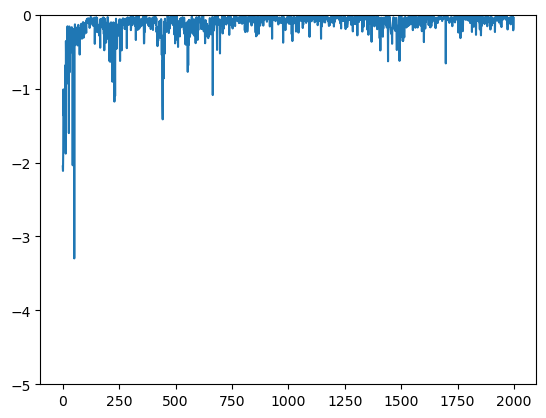

In [140]:
#from torch.distributions import Normal
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class ShootingNetwork(nn.Module):
    def __init__(self):
        super(ShootingNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)  # Output: speed and angle
        self.fc4 = nn.Linear(16, 2)  # Output: speed and angle stddev
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        means = F.sigmoid(self.fc3(x)) * torch.tensor([25.0, np.pi / 2.5])
        means[0]+=5
        stddevs = F.sigmoid(self.fc4(x))*torch.tensor([1.0, 0.1])
        return means, stddevs

class REINFORCE():
    def __init__(self, lr=0.005, gamma=0.99):
        self.shooting_policy = ShootingNetwork()
        self.optimizer = optim.Adam(
            list(self.shooting_policy.parameters()), lr=lr)
        self.gamma = gamma
        self.log_probs = []
        self.n_sample=40
        self.rewards = []
        self.loss=torch.tensor(0.0)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        shot_params, shot_stddev = self.shooting_policy(state)
        dist = torch.distributions.Normal(shot_params, shot_stddev+0.005)
        sampled_shot_L=[]
        log_prob_L=[]
        for i in range(self.n_sample):
            sampled_shot = dist.sample()
            sampled_shot_L.append(sampled_shot)
            log_prob = dist.log_prob(sampled_shot_L[-1]).sum()
            log_prob_L.append(log_prob)
        self.log_probs=log_prob_L
        return "shoot", [sampled_shot.detach().numpy() for sampled_shot in sampled_shot_L], state.item()

    def update_policy(self, it, itmax):  
        if it==1:     
            self.loss=torch.tensor(0.0)
        for i,rewards in enumerate(self.rewards):
          self.loss += -self.log_probs[i]*rewards
        self.optimizer.zero_grad()
        if it==itmax:
            self.loss.backward() 
            self.optimizer.step()
            self.loss=torch.tensor(0.0)
            it=0
        self.log_probs = []
        self.rewards = []
        return it

def simulate_shot(x, v, alpha):
    z = 1.8  # Initial height
    dt = 0.01
    vh = v * np.cos(alpha)
    vv = v * np.sin(alpha)
    # the reward needs to be a continous
    while x<30:
        x += vh * dt
        z += vv * dt
        vv -= 9.8 * dt
    distance=np.abs(z-3.05)
    return -0.5*distance
import tqdm
def train(agent, episodes=2000):
    reward_list=[]
    it=1 
    for itrain in tqdm.tqdm(range(episodes)):
        x_pos = np.random.randn()*5+15  # Initial player position
        state = np.array([(x_pos-15)/5])
        action_type, action_L, x_pos = agent.select_action(state)
        x_pos_in = x_pos*5+15
        last_reward_L=[]
        for action in action_L:
            reward = simulate_shot(x_pos_in, action[0], action[1])
            agent.rewards.append(reward)
            last_reward_L.append(reward)
        reward_list.append(np.array(agent.rewards).mean())
        
        it=agent.update_policy(it,1)
        it+=1
    return reward_list,last_reward_L,action_L, x_pos_in  

if __name__ == "__main__":
    agent = REINFORCE()
    reward_L,last_reward_L,action_L,x_pos_in=train(agent)

import matplotlib.pyplot as plt
plt.plot(reward_L)
plt.ylim(-5,0)


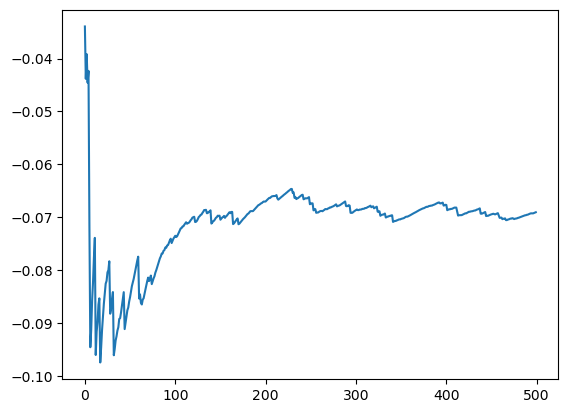

In [141]:

n_test=500
reward_list_test=[]
for iest in range(n_test):
    x_pos = np.random.randn()*5+15  # Initial player position
    state = np.array([(x_pos-15)/5])
    action_type, action_L, x_pos = agent.select_action(state)
    x_pos_in = x_pos*5+15
    for action in action_L:
        reward = simulate_shot(x_pos_in, action[0], action[1])
        agent.rewards.append(reward)
        
    reward_list_test.append(np.array(agent.rewards).mean())
plt.plot(reward_list_test)


In [129]:
print(reward_list_test)

[-0.024335719351768332, -0.030130028623104203, -0.02959202195707962, -0.034921488511324136, -0.03300588290872588, -0.060215823885361695, -0.05647568902908077, -0.05764858811193736, -0.05532903702645857, -0.05263867408404369, -0.05083376880350999, -0.05352545494119348, -0.0585430827756664, -0.057612292570761524, -0.05527947438535713, -0.05425309815558811, -0.05492152439956127, -0.05505733375549343, -0.05393179114218788, -0.0528042025501492, -0.05151681851668606, -0.05294287538251034, -0.06579291011412279, -0.0647059175071918, -0.06331044312307389, -0.06320841645902886, -0.06166200656716059, -0.06063970217251808, -0.06281680496602254, -0.061690673555803585, -0.061164304207940536, -0.06042752667854756, -0.05948212363140539, -0.06484624974400889, -0.06558842151809453, -0.06468884101518026, -0.064425703491469, -0.0635439444352956, -0.06268538186585627, -0.06197220987812308, -0.061222260594961386, -0.06215974567181751, -0.06214872060643824, -0.061917109973896926, -0.061211289274904754, -0.06

[15.563901   0.4067665]
[15.702809    0.40403008]
[15.581409    0.40492553]
[15.557547    0.40246812]
[15.640306    0.40188137]
[15.639227    0.40341896]
[15.559803  0.406244]
[15.594072    0.40525752]
[15.514319    0.40513706]
[15.630656   0.4025501]
[15.5570545   0.40354726]
[15.705624    0.40485865]
[15.612844    0.40733057]
[15.69706     0.40794834]
[15.6334305   0.40536466]
[15.684982    0.40519086]
[15.652349    0.40589494]
[15.650052    0.40601188]
[15.6530285   0.40248388]
[15.63378     0.39998096]
[15.584824    0.40537107]
[15.6116085   0.40590778]
[15.582678   0.4029788]
[15.715263   0.4107235]
[15.7261     0.4022257]
[15.527017    0.40350628]
[15.567902    0.40728444]
[15.671299   0.4081095]
[15.609596   0.4040601]
[15.671073    0.40589303]
[15.705322   0.4078414]
[15.626456    0.40150377]
[15.63779    0.4078449]
[15.644429   0.4038314]
[15.620374    0.40597895]
[15.630107    0.40625933]
[15.688056   0.4061409]
[15.620802    0.40546075]
[15.59559     0.40614992]
[15.629149  

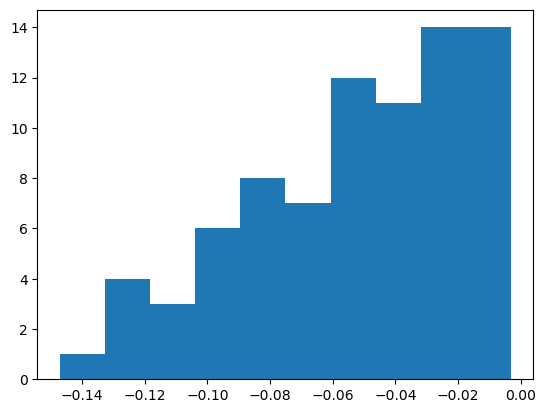

In [112]:
h1=plt.hist(last_reward_L)
for action in action_L:
    print(action)